In [1]:
import numpy as np
import pandas as pd
import math

In [3]:
# filters = np.random.randint(2, size= (1000, 100))
filters = pd.read_csv(r"C:\Users\joles\Downloads\ex_filter_set (1).csv").drop('Unnamed: 0', axis = 1)
filters

In [44]:

class Node:
    '''
    Multi-criterion decision tree to search the filter set.
    '''
    

    def __init__(self, theta:pd.DataFrame, depth=None, max_depth=None, num_filters=None):
        
        self.num_filters = num_filters if num_filters else 0
        # self.min_filters = min_filters if min_filters else 0

        self.depth = depth if depth else 0
        
        #Max depth = size of subset
        self.max_depth = max_depth if max_depth else 1

        #initialize left and right node to be empty
        self.left = None
        self.right = None

        #filter set
        self.theta = theta

        # initialise matched filter and weighted distance to None
        self.matched_filter = None
        self.min_distance = None
        
    def calc_weights(self, filters, depth):
        d = depth
        w1 = sum(filters[d])/(filters[d].shape[0])
        w2 = 1 - w1
        return w1, w2
    
    #returns the 'average' filter
    def GET_avg(self):
        sums = np.array([self.theta[col].sum() for col in self.theta.columns])
        return sums/(self.theta.shape[0])

    #calculate entropy on split element
    @staticmethod
    def calc_entropy(df):
        
        size = df.shape[0]
        props = [((df[col] == 0).sum(), (df[col] == 1).sum()) for col in df.columns]

        s = 0
        for prop in props:
            if prop[0]*prop[1] > 0:
                s = s + (prop[0]/size*np.log(prop[0]/size)) + (prop[1]/size*np.log(prop[1]/size))
        return -s 
    

    # information gain for split element
    
    def info_gains(self, data):
        size = data.shape[0]
        entropy_before = self.calc_entropy(data)
        info_gains = []
        for col in data.columns:
            left, right = data[data[col] == 0], data[data[col] == 1]
            left_size, right_size = left.shape[0], right.shape[0]
            entropy_after = (left_size/size)*self.calc_entropy(left) + (right_size/size)*self.calc_entropy(right)
            info_gains.append(entropy_before - entropy_after)
        return info_gains

    
    def build_tree(self):

        filters = self.theta

        self.split_elem = filters.columns[np.argmax(self.info_gains(filters))]
        
        l_split = filters[filters[self.split_elem] == 0]
        r_split = filters[filters[self.split_elem] == 1]   

        if (self.depth < self.max_depth) and (self.num_filters > 1):

            
            left = Node(l_split,
                        self.depth + 1,
                        self.max_depth,
                        num_filters = l_split.shape[0])
            
            self.left = left
            left.build_tree()

            right = Node(r_split,
                        self.depth + 1,
                        self.max_depth,
                        num_filters = r_split.shape[0])
             
            self.right = right
            right.build_tree()

    
    #Next three methods involve choosing correct branch based on Gaussian approach on 'n' iid filters. 
    #Filters may not be iid. Need to find a general method for choosing correct branch?
    def calc_mean_distance(self, subset, weights):
        return sum([weights[i] * (self.GET_avg()[i]+(1-2*self.GET_avg()[i])*subset[i]) for i in range(len(subset))])

    def calc_variance(self, weights):
        return sum([(weights[i]**2) * self.GET_avg()[i]*(1-self.GET_avg()[i]) for i in range(len(self.GET_avg()))])

    def choose_branch(self, subset, weights):

        #distance to average filter
        left_avg = self.left.calc_mean_distance(subset=subset, weights=weights)
        right_avg = self.right.calc_mean_distance(subset=subset, weights=weights)

        #calculate variance of distance
        left_var = self.left.calc_variance(weights=weights)
        right_var = self.right.calc_variance(weights=weights)

        #calculate minimum expected distance to average filter
        ex_distance_left = left_avg - pow(left_var, 0.5)*math.sqrt(2*np.log(self.left.theta.shape[0]))
        ex_distance_right = right_avg - pow(right_var, 0.5)*math.sqrt(2*np.log(self.right.theta.shape[0]))

        if ex_distance_left <= ex_distance_right:
            return self.left
        else:
            return self.right

        # return min(ex_distance_left , ex_distance_right)
        
    def traverse(self, subset, weights):
        while self.depth < self.max_depth:
            self = self.choose_branch(subset, weights)

        temp_min = 1000000000
        temp_filter = np.zeros(self.theta.shape[1])

        for i in range(self.theta.shape[0]):
            dist = sum(weights*abs(self.theta.iloc[i] - subset))
            if dist < temp_min:
                temp_min = dist
                temp_filter = self.theta.iloc[i]

        print("Best Matched Filter: \n{}\n  with weighted L1 distance of: {}".format(temp_filter, temp_min) )
    
    def printmatched(self):
        print(self.matched_filter)
        

In [45]:
theta = pd.DataFrame([[0, 1, 1, 0],
                     [0, 0, 1, 1],
                     [1, 1, 0, 0],
                     [1, 1, 1, 0],
                     [0, 1, 1, 1]])
subset = np.array([0,1,0,0])
weights = np.array([0.5,1,1,1])


theta2 = pd.DataFrame([[1, 1, 0, 0, 0],
                        [1, 1, 1, 0, 0],
                        [0, 1, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [0, 0, 0, 1, 1],
                        [0, 0, 1, 1, 0],
                        [0, 0, 1, 1, 1]])

subset2 = np.array([0, 1, 1, 1, 1])
weights2 = np.array([1, 0.5, 1, 1, 0.3])

root = Node(theta = theta2, max_depth = 1, num_filters=theta.shape[0])
root.build_tree()
root.traverse(subset2, weights2)

# print("Best Matched Filter: \n{}\n  with weighted L1 distance of: {}".format(root.matched_filter, root.min_distance) )
root.printmatched()

Best Matched Filter: 
0    0
1    0
2    1
3    1
4    1
Name: 6, dtype: int64
  with weighted L1 distance of: 0.5
None


In [68]:
import random

def generate_filters(n, filter=[], filter_set=[]):
    """
    Generates all filters of length n.
    """
    if n == 0:
        # Base case: add the current filter
        filter_set.append(filter)
    else:
        # Recursive case: generate vectors with 0 and 1 appended
        generate_filters(n-1, filter + [0], filter_set)
        generate_filters(n-1, filter + [1], filter_set)
    return filter_set

def delete_elements(lst, n):
  """
  Randomly deletes n elements from a list and returns a new list
  containing the deleted elements.
  """
  # Choose n random elements from the list
  deleted = random.sample(lst, n)

  # Create a new list containing the deleted elements
  deleted_list = [x for x in lst if x in deleted]

  # Remove the deleted elements from the original list
  for x in deleted:
    lst.remove(x)

  return lst, deleted_list

# Generate all binary vectors of length 6
theta = generate_filters(6)
theta, deleted = delete_elements(theta, len(theta)//2)

print(len(theta))
print(len(deleted))

subset = np.array(random.choice(deleted))
weights = np.random.rand(6)
print(subset)
print(weights)

theta = pd.DataFrame(theta)

root = Node(theta = theta, max_depth = 1, num_filters=theta.shape[0])
root.build_tree()
root.traverse(subset, weights)

32
32
[1 0 1 0 1 0]
[0.51063833 0.46086378 0.99807647 0.71256669 0.97330009 0.11747121]
Best Matched Filter: 
0    1
1    0
2    1
3    0
4    1
5    1
Name: 23, dtype: int64
  with weighted L1 distance of: 0.11747120884598095


<AxesSubplot:>

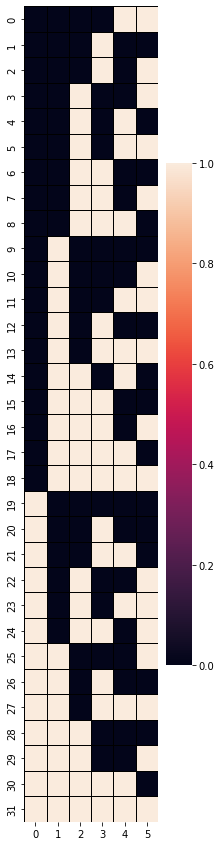

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[3,15])
sns.heatmap(theta, linewidths=1, linecolor='black')

<AxesSubplot:>

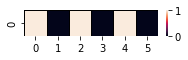

In [81]:
fig = plt.figure(figsize=[3,15/32])
sns.heatmap([subset], linewidths=1, linecolor='black')